In [13]:
import random
from collections import defaultdict
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [14]:
class Environment:
    def __init__(self, opponent):
        self.board = [[0]*3 for _ in range(3)]
        self.marker = {0: '-', 1:'X', 2:'O'}
        self.who_starts = random.choice([1,2]) # 1 is agent, 2 is opponent
        if self.who_starts == 2:
            move = opponent(self)
            self.act(move, 'opponent')

    def __str__(self):
        s = ''
        for row in self.board:
            for i in row:
                s += self.marker[i]+' '
            s += '\n'
        return s

    def check_win(self):
        for row in self.board:
            if row == [1, 1, 1] or row == [2, 2, 2]:
                return row[0]
        for column in zip(*self.board):
            if column == (1, 1, 1) or column == (2, 2, 2):
                return column[0]
        # diagonal
        if self.board[0][0] == self.board[1][1] == self.board[2][2]:
            return self.board[0][0]
        if self.board[2][0] == self.board[1][1] == self.board[0][2]:
            return self.board[1][1]

    def check_end(self):
        """checks in the game has ended"""
        return all([self.board[i][j] for i in range(3) for j in range(3)])

    def get_reward(self):
        win = self.check_win()
        if win:
            return 1 if win == 1 else -1
        end = self.check_end()
        if end:
            return -0.05
        return 0
    
    def act(self, action, who):
        dispatch = {'opponent': 2, 'player': 1}
        if not action: return
        self.board[action[0]][action[1]] = dispatch[who]
    
class RandomPlayer:
    @staticmethod
    def move(env):
        board = env.board
        available_moves = [(i, j) for i in range(3) for j in range(3) if not board[i][j]]
        if not available_moves: return None
        return random.choice(available_moves)


class SafePlayer:
    @staticmethod
    def move(env):
        board = env.board
        available_moves = [(i, j) for i in range(3) for j in range(3) if not board[i][j]]
        for i, j in available_moves:
            board[i][j] = 2
            win = env.check_win()
            board[i][j] = 0
            if win: return (i, j)
        for i, j in available_moves:
            board[i][j] = 1
            win = env.check_win()
            board[i][j] = 0
            if win: return (i, j)
        if not available_moves: return None
        return random.choice(available_moves)


def get_state(board):
    return tuple(tuple(i) for i in board)


class Agent:
    def __init__(self, discount_factor = 1):
        self.action_value = defaultdict(lambda: 0.4)
        self.gamma = discount_factor
    
    def take_action(self, state, board, epsilon):
        available_moves = []
        for i, row in enumerate(board):
            for j, val in enumerate(row):
                if not val:
                    available_moves.append((i, j))
        m = available_moves.__len__()
        probabilities = [epsilon/m]*m
        idx = max(list(range(m)),
            key = lambda x: self.action_value[(state, available_moves[x])]
            )
        probabilities[idx] += 1-epsilon
        action = random.choices(available_moves, weights = probabilities)[0]
        return action
    
    def update(self, lr, st, at, r, state, board):
        available_moves = []
        for i, row in enumerate(board):
            for j, val in enumerate(row):
                if not val:
                    available_moves.append((i, j))
        if available_moves:
            max_Qsa = max([self.action_value[(state, i)] for i in available_moves])
        else:  max_Qsa = 0
        self.action_value[(st, at)] += lr * (
            r + self.gamma * max_Qsa - self.action_value[(st, at)]
        )
    
    def __train_helper__(self, opponent: str, lr: float, epsilon:float):
        dispatch = {'random': RandomPlayer.move,
                    'safe': SafePlayer.move}
        opponent = dispatch[opponent]
        end = False
        env = Environment(opponent)
        while not end:
            state = get_state(env.board)
            action = self.take_action(state, env.board, epsilon)
            env.act(action, "player")
            reward = env.get_reward()
            if not reward:
                move = opponent(env)
                env.act(move, "opponent")
                reward = env.get_reward()
            end = reward != 0
            next_state = get_state(env.board)
            self.update(lr, state, action, reward, next_state, env.board)
    
    def train(self, num_games, opponent = None):
        enemy = opponent
        data = []
        for itr in range(1, num_games+1):
            if not opponent:
                enemy = random.choice(['random', 'safe'])
            self.__train_helper__(enemy, 2/itr, itr**(-0.05))
            if itr%200 == 0:
                wins, losses = self.test(100, opponent if opponent else 'random')
                data.append({'wins':wins, 'losses':losses})
        return data
    
    def test(self, num_games, opponent):
        wins, losses = 0, 0
        dispatch = {'random': RandomPlayer.move,
                    'safe': SafePlayer.move}
        if not opponent:
            enemy = random.choice(['random', 'safe'])
        else:
            enemy = opponent
        enemy = dispatch[enemy]
        for _ in range(num_games):
            end = False
            env = Environment(enemy)
            board = env.board
            while not end:
                state = get_state(env.board)
                action = self.take_action(state, board, 0)
                env.act(action, "player")
                reward = env.get_reward()
                if not reward:
                    move = enemy(env)
                    env.act(move, "opponent")
                    reward = env.get_reward()
                end = reward != 0
                if reward == 1: wins += 1
                if reward == -1: losses += 1
        return wins, losses

In [15]:
num_games = 10_000
plot_after = 200

wins against random: 868, losses against random: 75, draws against random: 57
wins against safe: 274, losses against safe: 447, draws against safe: 279


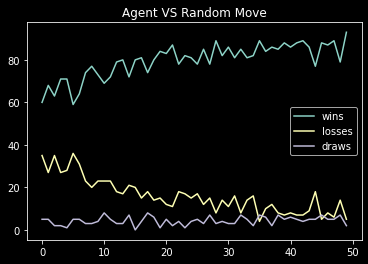

In [16]:
agent = Agent()
data = agent.train(num_games, opponent='random')
wins_random, losses_random = agent.test(1000, 'random')
wins_safe, losses_safe = agent.test(1000, 'safe')
print(f'wins against random: {wins_random}, losses against random: {losses_random}, draws against random: {1000-wins_random-losses_random}')
print(f'wins against safe: {wins_safe}, losses against safe: {losses_safe}, draws against safe: {1000-wins_safe-losses_safe}')

plt.plot([i for i in range(num_games//plot_after)], [i['wins'] for i in data], label = 'wins')
plt.plot([i for i in range(num_games//plot_after)], [i['losses'] for i in data], label = 'losses')
plt.plot([i for i in range(num_games//plot_after)], [100-i['wins']-i['losses'] for i in data], label = 'draws')
plt.title('Agent VS Random Move')
plt.legend()
plt.show()

wins against random: 706, losses against random: 145, draws against random: 149
wins against safe: 569, losses against safe: 150, draws against safe: 281


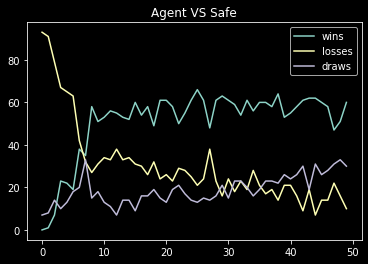

In [17]:
agent = Agent()
data = agent.train(num_games, opponent='safe')
wins_random, losses_random = agent.test(1000, 'random')
wins_safe, losses_safe = agent.test(1000, 'safe')
print(f'wins against random: {wins_random}, losses against random: {losses_random}, draws against random: {1000-wins_random-losses_random}')
print(f'wins against safe: {wins_safe}, losses against safe: {losses_safe}, draws against safe: {1000-wins_safe-losses_safe}')

plt.plot([i for i in range(num_games//plot_after)], [i['wins'] for i in data], label = 'wins')
plt.plot([i for i in range(num_games//plot_after)], [i['losses'] for i in data], label = 'losses')
plt.plot([i for i in range(num_games//plot_after)], [100-i['wins']-i['losses'] for i in data], label = 'draws')
plt.title('Agent VS Safe')
plt.legend()
plt.show()

wins against random: 866, losses against random: 76, draws against random: 58
wins against safe: 412, losses against safe: 272, draws against safe: 316


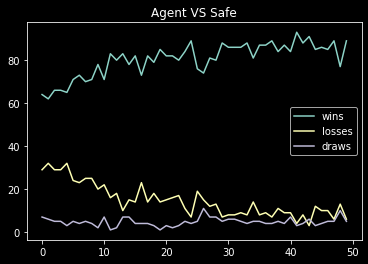

In [18]:
agent = Agent()
data = agent.train(num_games)
wins_random, losses_random = agent.test(1000, 'random')
wins_safe, losses_safe = agent.test(1000, 'safe')
print(f'wins against random: {wins_random}, losses against random: {losses_random}, draws against random: {1000-wins_random-losses_random}')
print(f'wins against safe: {wins_safe}, losses against safe: {losses_safe}, draws against safe: {1000-wins_safe-losses_safe}')

plt.plot([i for i in range(num_games//plot_after)], [i['wins'] for i in data], label = 'wins')
plt.plot([i for i in range(num_games//plot_after)], [i['losses'] for i in data], label = 'losses')
plt.plot([i for i in range(num_games//plot_after)], [100-i['wins']-i['losses'] for i in data], label = 'draws')
plt.title('Agent VS Safe')
plt.legend()
plt.show()

## Problem 2-c-4
The agent trained against the player that chooses safe move because it is able to win against both safe, random player. It wins substantial number of games against both random player and safe player. I observed that on average the agent trained against safe player wins around 150 games more than the agent trained against randomly agent.

## Problem 2-c-5
The agent isn't unbeatable as we can already see from the number of losses in the games. The agent can be improved by either increasing the number of games or training against minimax player which is an optimal player. We can also improve by using afterstates.